In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc
from tqdm import tqdm
from venn import venn, pseudovenn
from collections import defaultdict
from itertools import count, islice, chain
from functools import lru_cache

In [2]:
%matplotlib inline

In [3]:
from edgecaselib.formats import load_kmerscan, EmptyKmerscanError
from scipy.stats import entropy
from os import path
from pickle import load, dump
from gzip import open as gzopen

In [4]:
SUBJECT_TO_TRIO = {
    "HG001": "NA12878",
    "HG002": "AshkenazimTrio", "HG003": "AshkenazimTrio", "HG004": "AshkenazimTrio",
    "HG005": "ChineseTrio", "HG006": "ChineseTrio", "HG007": "ChineseTrio",
}

In [5]:
KMERSCANS_PKL = "PacBio/kmerscans-for-entropy.pkl.gz"

if path.isfile(KMERSCANS_PKL):
    with gzopen(KMERSCANS_PKL, mode="rb") as pkl:
        KMERSCANS = load(pkl)
else:
    KMERSCANS = {}
    for subject, trio in SUBJECT_TO_TRIO.items():
        try:
            ksp = load_kmerscan(
                f"PacBio/{trio}/{subject}/kmerscanner-all-p_arm.dat.gz",
                gzipped=True, samfilters=["tract_anchor", 3844, 0],
                bin_size=10,
            )
        except EmptyKmerscanError:
            ksp = {}
        try:
            ksq = load_kmerscan(
                f"PacBio/{trio}/{subject}/kmerscanner-all-q_arm.dat.gz",
                gzipped=True, samfilters=["is_q|tract_anchor", 3844, 0],
                bin_size=10,
            )
        except EmptyKmerscanError:
            ksq = {}
        KMERSCANS[subject] = (ksp, ksq)
    with gzopen(KMERSCANS_PKL, mode="wb") as pkl:
        dump(KMERSCANS, pkl)

In [6]:
def get_per_read_modes(bdf):
    return (
        bdf.groupby("name")
        .apply(lambda block: block.set_index("motif").iloc[:,8:].idxmax(axis=0))
        .dropna(how="all", axis=1)
    )

In [7]:
def calculate_entropies(bdf):
    per_read_modes = get_per_read_modes(bdf)
    N = len(per_read_modes.melt().value.dropna().unique())
    return pd.DataFrame({
        "entropy": per_read_modes.apply(lambda c: entropy(c.value_counts())) / np.log(N),
        "coverage": (~per_read_modes.isnull()).sum(axis=0),
    })

In [8]:
ENTROPIES_DICT = {
    subject: pd.concat(
        calculate_entropies(bdf)
        for bdf in tqdm(
            chain(ksp.values(), ksq.values()),
            desc=subject, unit="arm",
            total=len(ksp)+len(ksq),
        )
    )
    for subject, (ksp, ksq) in KMERSCANS.items()
}

HG007: 100%|██████████| 24/24 [00:54<00:00,  2.26s/arm]


In [9]:
def weighted_quantile(points, weights, q):
    indsort = np.argsort(points.values)
    spoints, sweights = points.values[indsort], weights.values[indsort]
    sn = np.cumsum(sweights)
    pn = (sn - sweights / 2) / sn[-1]
    return np.interp(q, pn, spoints)

Plotting: 100%|██████████| 7/7 [00:30<00:00,  4.33s/it]


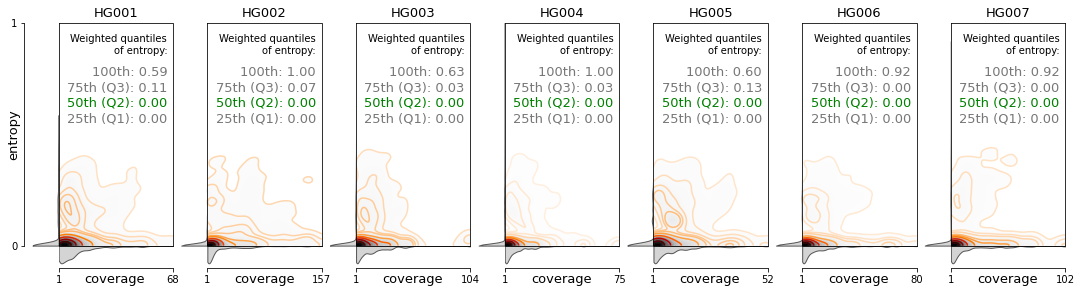

In [56]:
def plot_entropies(entropies_dict, downsample_viz=1, scale=1, cmap_2d="Greys", vmin_2d=-.009, cmap_levels="gist_heat_r", vmin_levels=-.003):
    width_ratios = [.75, 2.5] * len(entropies_dict)
    height_ratios = [5, .5]
    figure, axs = subplots(
        figsize=(sum(width_ratios)*scale, sum(height_ratios)*scale),
        ncols=len(width_ratios), nrows=len(height_ratios), squeeze=False,
        gridspec_kw=dict(width_ratios=width_ratios, wspace=0, height_ratios=height_ratios, hspace=0),
    )
    for i, (subject, entropies) in tqdm(enumerate(entropies_dict.items()), desc="Plotting", total=len(entropies_dict)):
        maxcov = entropies["coverage"].max()
        ax2d = axs[0,i*2+1]
        kde2d_kws=dict(data=entropies[::downsample_viz], x="coverage", y="entropy", cut=0, ax=ax2d)
        sns.kdeplot(**kde2d_kws, levels=50, fill=True, cmap=cmap_2d, vmin=vmin_2d)
        sns.kdeplot(**kde2d_kws, levels=10, fill=False, cmap=cmap_levels, vmin=vmin_levels)
        ax2d.set(xlabel=None, ylabel=None, ylim=(0, 1), xticks=[], yticks=[])
        ax2d.set_title(subject, fontsize=13)
        ax2d.text(x=maxcov*.95, y=.95, ha="right", va="top", s="Weighted quantiles\nof entropy:")
        for q, y, desc in zip([.25, .5, .75, 1], [.6, .67, .74, .81], ["25th (Q1)", "50th (Q2)", "75th (Q3)", "100th"]):
            qval = weighted_quantile(entropies["entropy"], entropies["coverage"]-1, q)
            color = "green" if (q == .5) else "#777"
            ax2d.text(x=maxcov*.95, y=y, ha="right", va="top", s=f"{desc}: {qval:.2f}", color=color, fontsize=13)
        ax_e = axs[0,i*2]
        sns.kdeplot(data=entropies, y="entropy", cut=0, ax=ax_e, shade=True, color="#555")
        ax_e.set(
            xlim=(ax_e.get_xlim()[1]*1.25, 0),
            ylim=(0, 1),
            xticks=[], yticks=[], xlabel=None, ylabel=None,
        )
        for spine in "top", "bottom":
            ax_e.spines[spine].set_visible(False)
        ax_c = axs[1,i*2+1]
        sns.kdeplot(data=entropies, x="coverage", cut=0, ax=ax_c, shade=True, color="#555")
        ax_c.set(
            xlim=(1, maxcov), ylim=(ax_c.get_ylim()[1]*1.2, 0),
            xticks=[1, maxcov], xlabel=None, yticks=[], ylabel=None,
        )
        ax_c.text(x=maxcov/2, y=ax_c.get_ylim()[0]*1.22, s="coverage", ha="center", va="top", fontsize=13)
        for spine in "left", "right":
            ax_c.spines[spine].set_visible(False)
        axs[1,i*2].set(frame_on=False, xticks=[], yticks=[], xlim=(0, 1), ylim=(0, 1))
    axs[0,0].set(yticks=[0, 1])
    axs[0,0].text(x=axs[0,0].get_xlim()[0]*1.12, y=.5, s="entropy", rotation=90, ha="right", va="center", fontsize=13)
    return figure

figure = plot_entropies(ENTROPIES_DICT, downsample_viz=20, vmin_2d=-.015, vmin_levels=-.035, scale=.82)
figure.savefig("Figure-3.pdf", bbox_inches="tight")